In [1]:
# autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

import pathmagic
from tools.project import proj_dir

In [2]:
from tools.tools import load_tensor_image, load_blender_flow_exr, to_tensor_crop
from tools.vis_tools import plot_tensor_grid, flow_to_vis
import matplotlib.pyplot as plt
import torch

flow_basename = "flow{:0>4d}.exr"
#image_basename = "allinfocus{:0>4d}.tif"
image_basename = "color{:0>4d}.tif"

#folder = "/home/kevin/Documents/master-thesis/render/DiningRoom1"
folder = "/home/kevin/Documents/master-thesis/datasets/s7_test_allinfocus/test/seq0"

size = 448
num_frames = 25

imgs = torch.stack([
    load_tensor_image(os.path.join(folder, image_basename.format(i)), size)
    for i in range(num_frames)
]).cuda()

flows = torch.stack([
    to_tensor_crop(load_blender_flow_exr(os.path.join(folder, flow_basename.format(i))), size)
    for i in range(num_frames - 1)
]).cuda()

print(imgs.shape, flows.shape)

/home/kevin/miniconda2/envs/torch/lib/python3.6/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU0 GeForce GTX 660M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


torch.Size([25, 3, 448, 448]) torch.Size([24, 2, 448, 448])


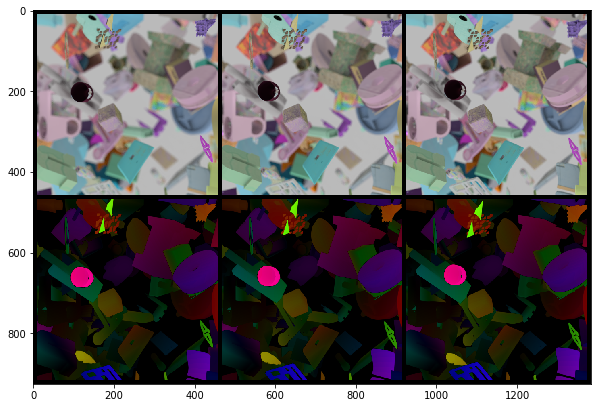

In [3]:
plt.figure(figsize=(10,10))
plot_tensor_grid([*imgs[0:3], *flow_to_vis(flows[0:3])], nrow=3)

In [4]:
from net.flownet2 import FlowNet2
from model_setup.pretrained_pool import _load_flownet_nvidia


with torch.no_grad():
    net = FlowNet2().cuda()
    net.eval()
    _load_flownet_nvidia(net)
    
    flow_predict = net(imgs.unsqueeze(0))[0]
    flow_24_to_0_predict = net(imgs[[0, 24]].unsqueeze(0))[0]

/home/kevin/miniconda2/envs/torch/lib/python3.6/site-packages/torch/nn/functional.py:2493: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [5]:
print(imgs.shape)
print(flow_predict.shape)

torch.Size([25, 3, 448, 448])
torch.Size([24, 2, 448, 448])


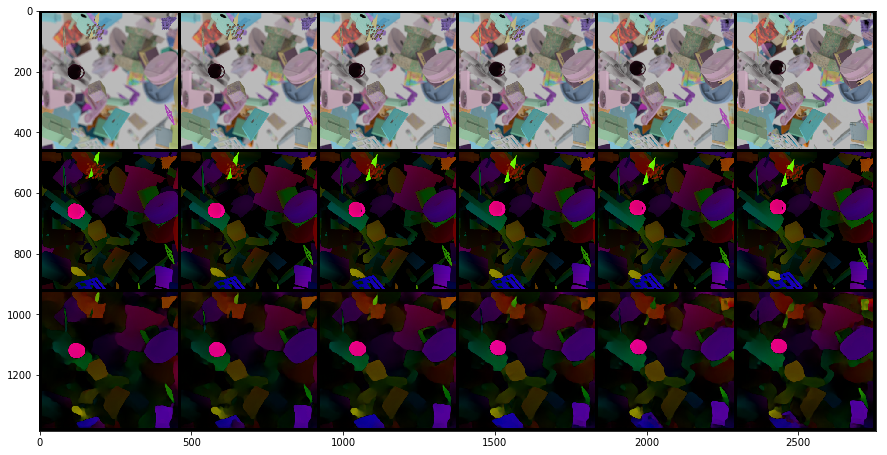

In [6]:
num_imgs = 6
plt.figure(figsize=(15,10))
plot_tensor_grid([*imgs[0:num_imgs], *flow_to_vis(flows[0:num_imgs]), *flow_to_vis(flow_predict[0:num_imgs])], nrow=num_imgs)

In [7]:
from net.flownet2 import MultiWarp, FlowComposite, Warp

flow_composite = FlowComposite()

warp = Warp()
multi_warp_composite_flow = MultiWarp(use_composite_flow=True)
multi_warp = MultiWarp(use_composite_flow=False)

flow_24_to_0 = flow_composite(flows.unsqueeze(0))[0]

img_24_to_0 = multi_warp(imgs[-1].unsqueeze(0), flows.unsqueeze(0))[0]
img_24_to_0_composite_flow = multi_warp_composite_flow(imgs[-1].unsqueeze(0), flows.unsqueeze(0))[0]
img_24_to_0_warp_direct = warp(imgs[-1].unsqueeze(0), flow_24_to_0_predict.unsqueeze(0))[0]

print(flow_24_to_0.shape, img_24_to_0.shape, img_24_to_0_composite_flow.shape)

torch.Size([2, 448, 448]) torch.Size([3, 448, 448]) torch.Size([3, 448, 448])


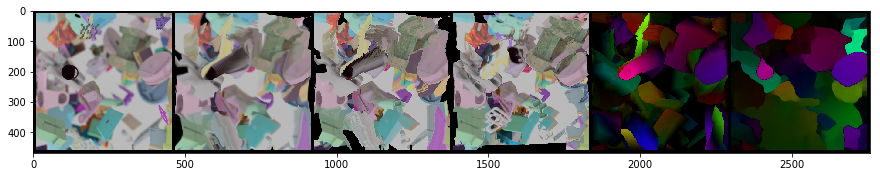

In [8]:
plt.figure(figsize=(15,10))
plot_tensor_grid([imgs[0], 
                  img_24_to_0, 
                  img_24_to_0_composite_flow, 
                  img_24_to_0_warp_direct,
                  flow_to_vis(flow_24_to_0),
                  flow_to_vis(flow_24_to_0_predict)], nrow=num_imgs)